In [40]:
import sys
import os
from matplotlib.colors import LinearSegmentedColormap
sys.path.append('/root/capsule/code/beh_ephys_analysis')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
from pynwb import NWBFile, TimeSeries, NWBHDF5IO
from scipy.io import loadmat
from scipy.stats import zscore
from pathlib import Path
import glob
import json
import seaborn as sns
from PyPDF2 import PdfMerger
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import re
from utils.beh_functions import session_dirs, parseSessionID, load_model_dv, makeSessionDF, get_session_tbl, get_unit_tbl, get_history_from_nwb
from utils.ephys_functions import*
from utils.ccf_utils import ccf_pts_convert_to_mm, pir_to_lps, project_to_plane
from utils.combine_tools import apply_qc, to_str_intlike, spatial_dependence_summary, binary_shift_P_vs_U, welch_shift_P_vs_U
import pickle
import scipy.stats as stats
import spikeinterface as si
import shutil
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import r2_score
import warnings
from scipy.stats import gaussian_kde
import trimesh
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
from utils.ccf_utils import ccf_pts_convert_to_mm
from trimesh import load_mesh
from scipy.stats import pearsonr
import statsmodels.api as sm
from aind_ephys_utils import align
import k3d
from scipy.stats import rankdata
from scipy.ndimage import binary_dilation
from skimage.measure import find_contours
from joblib import Parallel, delayed
warnings.filterwarnings('ignore')

%matplotlib inline

In [41]:
# load basic ephys
target_folder = '/root/capsule/scratch/manuscript/F_basicephys'
be_folder = os.path.join('/root/capsule/scratch/combined/beh_plots', 'basic_ephys')
be_file = os.path.join(be_folder, f'basic_ephys.pkl')
with open(be_file, 'rb') as f:
    basic_ephys_df = pickle.load(f)
filter = basic_ephys_df['be_filter'].values
filter = np.array(filter, dtype=bool)
basic_ephys_df['be_filter'] = filter
basic_ephys_df.rename(columns={'unit': 'unit_id'}, inplace=True)
basic_ephys_df['unit_id'] = basic_ephys_df['unit_id'].apply(to_str_intlike)

In [42]:
with open(os.path.join('/root/capsule/scratch/combined/combine_unit_tbl', 'combined_unit_tbl.pkl'), 'rb') as f:
    combined_tagged_units = pickle.load(f)
combined_tagged_units.rename(columns={'unit': 'unit_id'}, inplace=True)
combined_tagged_units['unit_id'] = combined_tagged_units['unit_id'].apply(to_str_intlike)
# antidromic data
version = 'PrL_S1'
antidromic_file = f'/root/capsule/scratch/combined/beh_plots/basic_ephys/{version}/combined_antidromic_results.pkl'
with open(antidromic_file, 'rb') as f:
    antidromic_df = pickle.load(f)

antidromic_df.rename(columns={'unit': 'unit_id'}, inplace=True)
antidromic_df['unit_id'] = antidromic_df['unit_id'].apply(to_str_intlike)
antidromic_df = antidromic_df[['unit_id', 'session', 'p_auto_inhi', 't_auto_inhi',
       'p_collision', 't_collision', 'p_antidromic', 't_antidromic', 'tier_1',
       'tier_2', 'tier_1_long', 'tier_2_long']].copy()
combined_tagged_units = combined_tagged_units.merge(antidromic_df, on=['session', 'unit_id'], how='left')
combined_tagged_units['tier_1'].fillna(False, inplace=True)
combined_tagged_units['tier_2'].fillna(False, inplace=True)
combined_tagged_units['tier_1_long'].fillna(False, inplace=True)
combined_tagged_units['tier_2_long'].fillna(False, inplace=True)


Applying conditional bounds for isi_violations
 - isi_violations: 18300 -> 8346 units passed
Applying items for qc_pass: [True]
 - qc_pass: 8346 -> 5873 units passed
Applying bounds for peak: [-1000, 500]
 - peak: 5873 -> 5850 units passed
Applying bounds for sd: [0, 0.3]
 - sd: 5850 -> 2969 units passed
Applying conditional bounds for y_loc
 - y_loc: 2969 -> 2410 units passed
Applying opto conditions: ['p_max', 'eu', 'corr', 'tag_loc', 'lat_max_p', 'p_mean', 'sig_counts']
Number of opto rows after filtering: 412
Number of non-opto rows after filtering: 2410


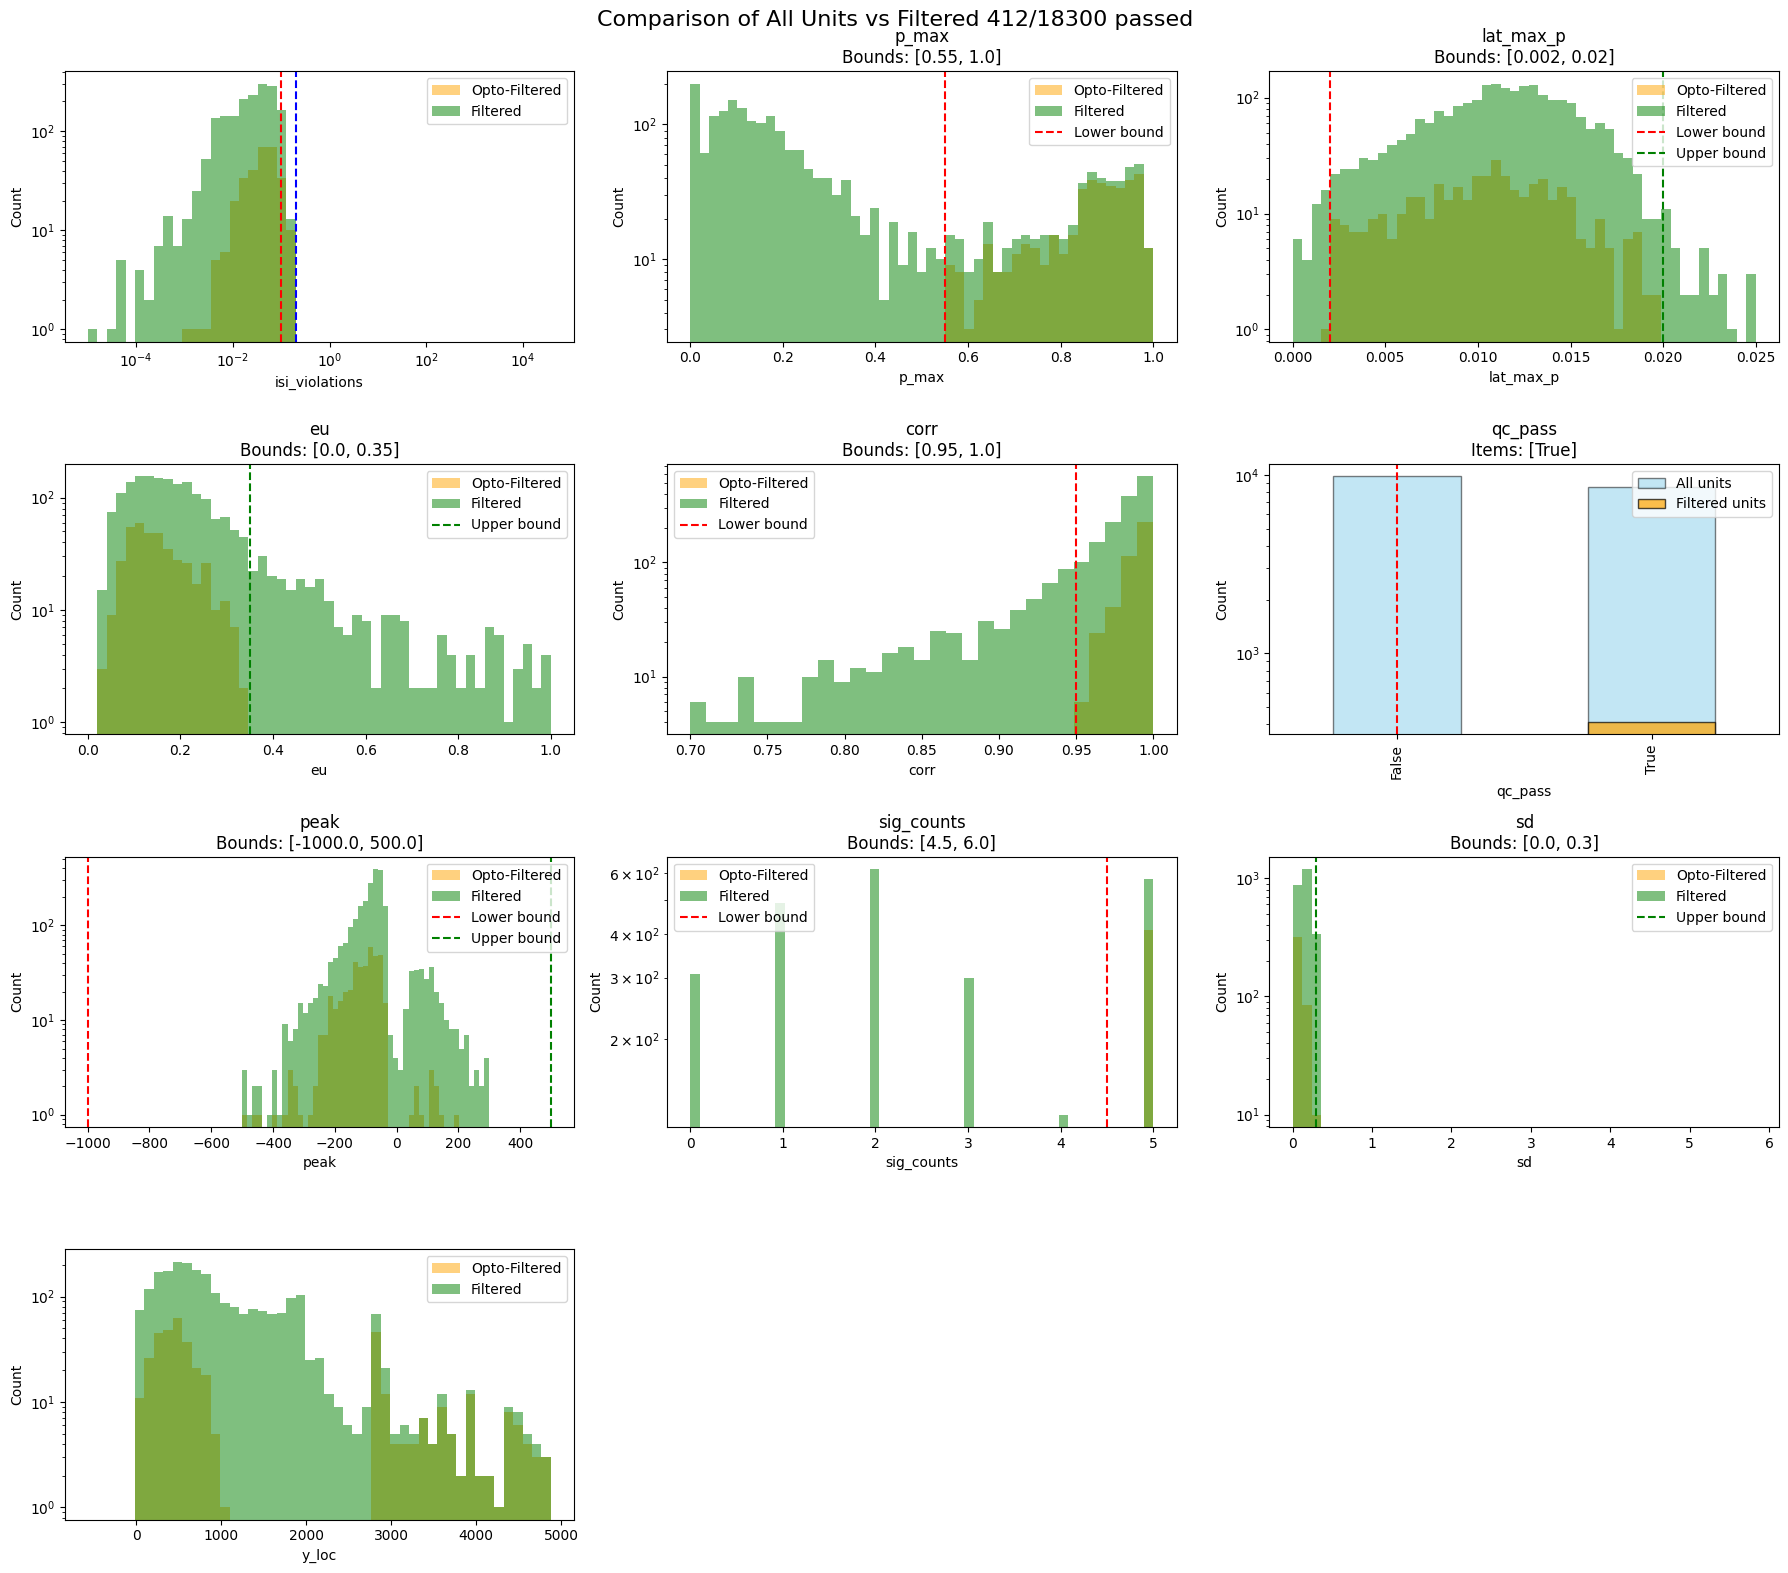

In [43]:
density = False
criteria_name = 'basic_ephys_all'
with open(os.path.join('/root/capsule/code/beh_ephys_analysis/session_combine/metrics', f'{criteria_name}.json'), 'r') as f:
    constraints = json.load(f)
    
combined_tagged_units_filtered, combined_tagged_units, fig, axes = apply_qc(combined_tagged_units, constraints, density=density, plot_all=False)
combined_tagged_units.rename(columns={'unit': 'unit_id'}, inplace=True)
combined_tagged_units['unit_id'] = combined_tagged_units['unit_id'].apply(to_str_intlike)
combined_tagged_units_filtered.rename(columns={'unit': 'unit_id'}, inplace=True)
combined_tagged_units_filtered['unit_id'] = combined_tagged_units_filtered['unit_id'].apply(to_str_intlike)


In [44]:

fig.savefig(fname=os.path.join(target_folder, f'unit_quality_metrics_summary_density_{density}.pdf'))
fig.savefig(fname=os.path.join(target_folder, f'unit_quality_metrics_summary_density_{density}.svg'))

In [45]:
features_combined = basic_ephys_df.merge(combined_tagged_units_filtered, on=['session', 'unit_id'], how='inner')

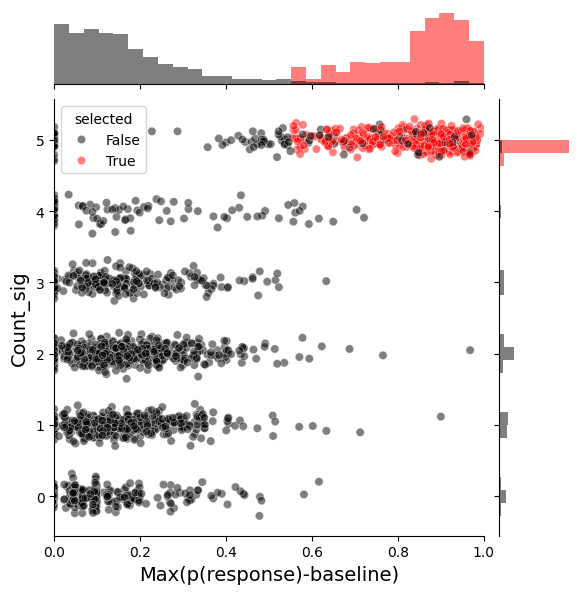

In [46]:

# opto tagged vs not
# Define color palette for groups
palette = {True: "r", False: "k"}
x_col = 'p_max'
y_col = 'sig_counts'

combined_tagged_units_plot = combined_tagged_units.copy()
combined_tagged_units_plot[y_col] = combined_tagged_units_plot[y_col]  + np.random.normal(0, 0.1, size=len(combined_tagged_units_plot[y_col]))  # add jitter to y-axis for better visibility

# Create JointGrid
g = sns.JointGrid(data=combined_tagged_units_plot[combined_tagged_units['selected_qc_only']], x=x_col, y=y_col, hue='selected', palette=palette)

# Add scatter plot in the center
g.plot_joint(sns.scatterplot, alpha=0.5)
g.ax_joint.set_xlim(0, 1)
g.ax_joint.set_xlabel('Max(p(response)-baseline)', fontsize=14)
g.ax_joint.set_ylabel('Count_sig', fontsize=14)

# Add histograms manually for each group
p_max_bins = np.linspace(0, 1, 30)
y_bins = np.linspace(combined_tagged_units_plot[combined_tagged_units['selected_qc_only']][y_col].min(), combined_tagged_units[combined_tagged_units['selected_qc_only']][y_col].max(), 30)
for qc_val, color in palette.items():
    subset = combined_tagged_units_plot[combined_tagged_units['selected_qc_only'] & (combined_tagged_units['selected'] == qc_val)]
    # Horizontal histogram for x-axis (default orientation)
    ax = g.ax_marg_x
    ax.hist(subset[x_col], bins=p_max_bins, color=color, alpha=0.5, edgecolor='none', density='True')

    # **VERTICAL histogram for y-axis** using orientation="horizontal"
    ax = g.ax_marg_y
    ax.hist(subset[y_col], bins=y_bins, color=color, alpha=0.5, edgecolor='none', density='True',  orientation='horizontal')
    # sns.histplot(y=subset['lat_max_p'], ax=g.ax_marg_y, bins=lat_max_p_bins, color=color, alpha=0.5, edgecolor='none')

plt.savefig(os.path.join(target_folder, f'opto_pass_{x_col}_{y_col}_{criteria_name}.pdf'), dpi=300, bbox_inches='tight')
# Show plot
plt.show()



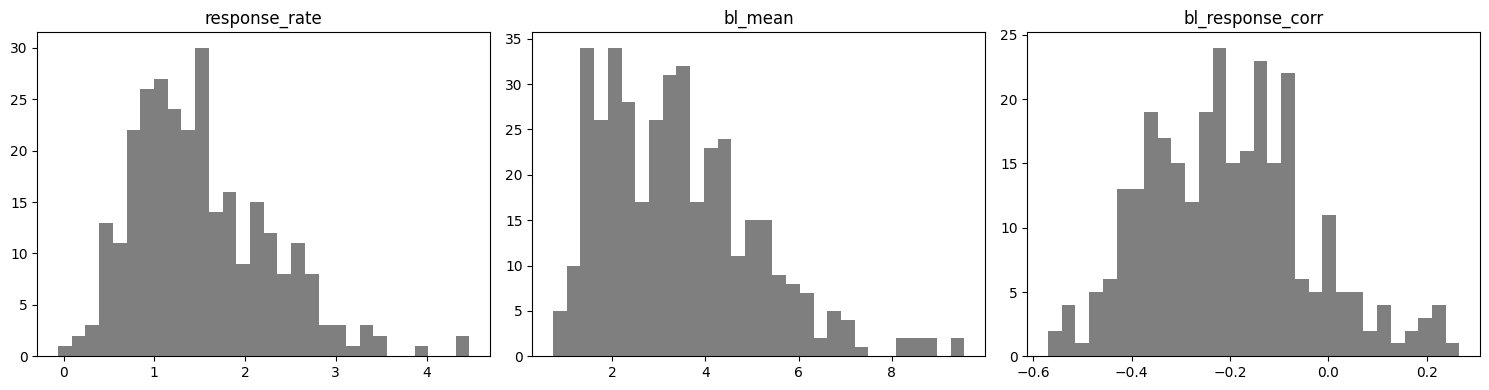

In [47]:
focus_features = ['response_rate', 'bl_mean', 'bl_response_corr']
# histograms of all-focus cols
fig, axes = plt.subplots(1, len(focus_features), figsize=(5 * len(focus_features), 4))
for i, col in enumerate(focus_features):
    axes[i].hist(features_combined[col], facecolor='k', edgecolor=None, alpha=0.5, bins=30)
    axes[i].set_title(f'{col}')
plt.tight_layout()
plt.savefig(os.path.join(target_folder, f'focus_features.pdf'), dpi=300, bbox_inches='tight')


## Plot distribution in space

In [48]:
from matplotlib.colors import Normalize
ml, ap, dv = 0, 1, 2
planes = {'sag': [ap, dv], 'hor': [ml, ap], 'cor': [ml, dv]}

norm = Normalize(vmin=0, vmax=1)
mesh = load_mesh('/root/capsule/scratch/combined/ccf_maps/20250418_transformed_remesh_10_ccf25.obj')
mesh_vertices = np.array(mesh.vertices)
mesh_vertices = (mesh_vertices - np.array([216, 18, 228]))*25/1000
mesh_vertices_lps = pir_to_lps(mesh_vertices) # convert to lps
mesh_vertices_mm = mesh_vertices_lps
# mesh_vertices_mm[:, ml] = -mesh_vertices_mm[:, ml]

# --- 3D anatomical points ---
ccfs = features_combined[['x_ccf', 'y_ccf', 'z_ccf']].values
bregma_LPS_mm = np.array([-5.7, 5.4, -0.45])  # in mm
ccfs = ccfs - bregma_LPS_mm
ml, ap, dv = 0, 1, 2
ccfs[:, ml] = np.abs(ccfs[:, ml])  # mirror ML to left hemisphere

In [49]:
# precompute mesh contours for each plane (for speed)
mesh_contours = {
    plane_name: project_to_plane(mesh_vertices_mm, plane_axes, pitch=0.02, margin=0.5)
    for plane_name, plane_axes in planes.items()
}

In [50]:
from matplotlib.colors import LinearSegmentedColormap


# Custom single-color colormap: light gray → full red
colors = [(0.4, 0.4, 0.4), (0.6, 0.3, 0.3), (1.0, 0.0, 0.0)]  # RGB for low/high
cmap = LinearSegmentedColormap.from_list('custom_red', colors)

In [51]:
# perform spatial dependence analysis for all features
spatial_dependence_results = {}
for feature_name in focus_features:
    values = features_combined[feature_name].values
    result = spatial_dependence_summary(
        ccfs,
        values,
        k_neighbors=30,
        n_splits=5,
        permutations=2000,
        seed=42,
    )
    spatial_dependence_results[feature_name] = result

In [52]:
# multiple comparison correction (FDR)
from statsmodels.stats.multitest import multipletests
# for knn
p_values = [spatial_dependence_results[feat]['cv_predictability_knn']['p_value_permutation'] for feat in focus_features]
reject, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')
for i, feature_name in enumerate(focus_features):
    spatial_dependence_results[feature_name]['cv_predictability_knn']['p_value_permutation_fdr'] = pvals_corrected[i]
    spatial_dependence_results[feature_name]['cv_predictability_knn']['significant_fdr'] = reject[i]
# for trend
p_values = [spatial_dependence_results[feat]['linear_trend']['p_value_F_test_vs_intercept_only'] for feat in focus_features]
reject, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')
for i, feature_name in enumerate(focus_features):
    spatial_dependence_results[feature_name]['linear_trend']['p_value_F_test_vs_intercept_only_fdr'] = pvals_corrected[i]
    spatial_dependence_results[feature_name]['linear_trend']['significant_fdr'] = reject[i]
# save results
# save results
results_file = os.path.join(target_folder, f'spatial_dependence_results_{criteria_name}.pkl')
with open(results_file, 'wb') as f:
    pickle.dump(spatial_dependence_results, f)

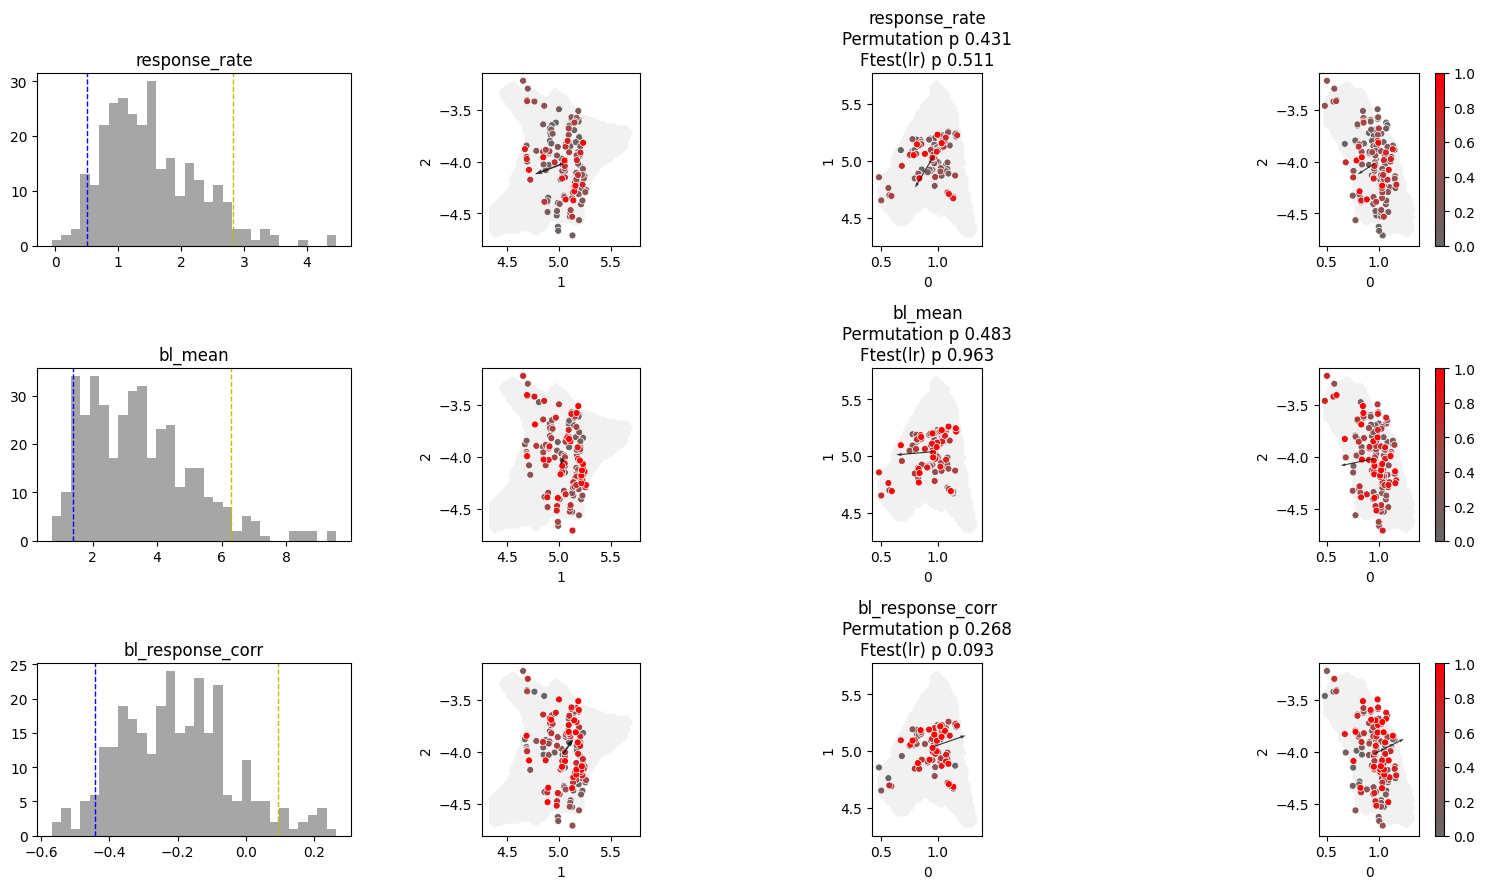

In [53]:
from matplotlib.colors import Normalize
from scipy.stats import rankdata
# -------------------------------------------------------------------------
# Main figure: plot CCA behavioral components in CCF space
# -------------------------------------------------------------------------
filter = features_combined['isi_violations'].values < 0.5
# CCF coordinates and planes
ccfs = features_combined[['x_ccf', 'y_ccf', 'z_ccf']].values[filter]
bregma_LPS_mm = np.array([-5.74, 5.4, -0.45])
ccfs = ccfs - bregma_LPS_mm
ccfs[:, ml] = np.abs(ccfs[:, ml])  # mirror ML to left
planes = {'sag': [ap, dv], 'hor': [ml, ap], 'cor': [ml, dv]}
bin_num = 4
# Precompute high-resolution mesh contours
mesh_contours = {
    plane_name: project_to_plane(mesh_vertices_lps, plane_axes, pitch=0.02, margin=0.5)
    for plane_name, plane_axes in planes.items()
}

fig, axes = plt.subplots(len(focus_features), 4, figsize=(15, 3*len(focus_features)))

for ind, feature in enumerate(focus_features):
    ax = axes[ind, 0]
    color_code = features_combined[feature].values
    ax.hist(color_code, bins=30, color='gray', alpha=0.7)
    ax.set_title(feature)
    valid_ind  = ~np.isnan(color_code)
    top_90 = np.quantile(color_code[valid_ind], 0.95)
    bottom_10 = np.quantile(color_code[valid_ind], 0.05)
    ax.axvline(top_90, color='y', linestyle='--', linewidth=1)
    ax.axvline(bottom_10, color='blue', linestyle='--', linewidth=1)
    color_code_nl = color_code.copy()
    color_code_nl[color_code > top_90] = top_90
    color_code_nl[color_code < bottom_10] = bottom_10
    color_code_nl = (color_code_nl - bottom_10) / (top_90 - bottom_10)  # Normalize color code to [0, 1] using 10-90% quantiles
    # change to rank
    # color_code_nl = rankdata(color_code_nl) / len(color_code_nl)
    sort_ind = np.argsort(color_code_nl)
    # sort_ind = np.random.permutation(sort_ind)  # randomize the order within same color
    # bin_edges = np.quantile(color_code, np.linspace(0, 1, bin_num + 1))
    # ax = axes[ind, -1]
    # for b in range(bin_num):
    #     bin_mask = (color_code >= bin_edges[b]) & (color_code < bin_edges[b + 1])
    #     mean_wf = np.nanmean(all_wfs_nl[filter][bin_mask], axis=0)
    #     mean_sem = np.nanstd(all_wfs_nl[filter][bin_mask], axis=0) / np.sqrt(np.sum(bin_mask))
    #     ax.plot(pc_time, mean_wf, label=f'Bin {b + 1} ({bin_edges[b]:.2f}-{bin_edges[b + 1]:.2f})', 
    #             color=cmap(b / (bin_num - 1)), linewidth=2)
    #     ax.fill_between(pc_time, mean_wf - mean_sem, mean_wf + mean_sem, color=cmap(b / (bin_num - 1)), 
    #                     alpha=0.3)
    for plane, ax in zip(planes.keys(), axes[ind, 1:]):
        # Plot the mesh
        for c in mesh_contours[plane]:
            ax.fill(c[:, 0], c[:, 1], color='lightgray', alpha=0.3, linewidth=0)
        # Plot the points
        sc = ax.scatter(ccfs[sort_ind, planes[plane][0]], ccfs[sort_ind, planes[plane][1]], c=color_code_nl[sort_ind], cmap=cmap, s=25, edgecolor=[1, 1, 1], alpha=1, linewidth=0.5)
        # add estimated arrow from linear trend
        coef = spatial_dependence_results[feature]['linear_trend']['coef_const_x_y_z']
        arrow_start = np.nanmean(ccfs, axis=0)
        arrow_vec = np.array([coef[1], coef[2], coef[3]])/np.linalg.norm([coef[1], coef[2], coef[3]])
        ax.quiver(
            arrow_start[planes[plane][0]],
            arrow_start[planes[plane][1]],
            arrow_vec[planes[plane][0]],
            arrow_vec[planes[plane][1]],
            angles='xy', scale_units='xy', scale=3,
            color='k', width=0.01, alpha=0.8
        )

        if plane == 'hor':
            if spatial_dependence_results[feature]['cv_predictability_knn']['significant_fdr']:
                title_color = 'red'
            else:
                title_color = 'black'
            ax.set_title(
                f"{feature}\n"
                f"Permutation p {spatial_dependence_results[feature]['cv_predictability_knn']['p_value_permutation_fdr']:.3f}\n"
                f"Ftest(lr) p {spatial_dependence_results[feature]['linear_trend']['p_value_F_test_vs_intercept_only_fdr']:.3f}",
                color=title_color
            )
        ax.set_xlabel(planes[plane][0])
        ax.set_ylabel(planes[plane][1])
        # set equal aspect ratio
        ax.set_aspect('equal')
        # if planes[plane][1] == dv: 
        #     ax.invert_yaxis()
            # ax.set_ylim(-5, -3)
        if plane == 'cor':
            fig.colorbar(sc, ax=ax, orientation='vertical', fraction=0.05)
            

plt.tight_layout()
plt.savefig(os.path.join(target_folder, f'basic_ephys_feature_in_space_{criteria_name}.pdf'), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(target_folder, f'basic_ephys_feature_in_space_{criteria_name}.svg'), dpi=300, bbox_inches='tight')

In [70]:
# plot all autocorrelograms
auto_corr = features_combined['acg_bl'].values

In [71]:
auto_inhi_bin = 0.05
window_length = 2

x_vals = np.array(range(int(window_length/auto_inhi_bin))) * auto_inhi_bin

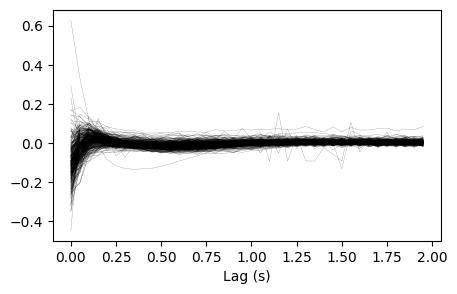

In [79]:
fig = plt.figure(figsize=(5, 3))
plt.plot(x_vals, np.array(auto_corr.tolist()).T, color='k', alpha=0.5, linewidth=0.2);
plt.xlabel('Lag (s)')
fig.savefig(os.path.join(target_folder, f'basic_ephys_all_autocorr_{criteria_name}.pdf'), dpi=300, bbox_inches='tight')

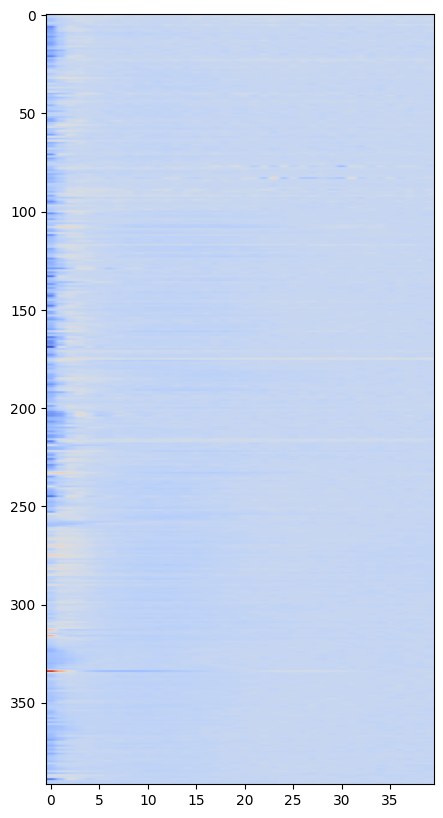

In [73]:
fig = plt.figure(figsize=(5, 10))
plt.imshow(np.array(auto_corr.tolist()), aspect='auto', cmap='coolwarm')